# Translating Constraints into QUBOs for the  Quadratic Knapsack Problem
```python

In [570]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit_aer.primitives import Estimator as AerEstimator
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

# Parámetros del problema QKP

In [571]:
# n_items = 7
# weights = [37, 10, 24, 27, 11, 19, 35]
# profits = np.array([[44, 64, 64, 70, 47, 47, 0],
#                     [64, 47, 0, 0, 0, 41, 54],
#                     [64, 0, 1, 11, 12, 8, 15],
#                     [70, 0, 11, 0, 6, 2, 28],
#                     [47, 0, 12, 6, 21, 0, 0],
#                     [47, 41, 8, 2, 0, 46, 15],
#                     [0, 54, 15, 28, 0, 15, 39]])
# capacity = 85

# penalty_factor = 3000
# # total_possible_profit = np.sum(profits)
# # total_possible_weight = 83

# # penalty_factor = total_possible_profit / (total_possible_weight-capacity)**2
# # print(f"Penalty factor: {penalty_factor}")

In [ ]:
n_items = 4
weights = [1, 1, 1, 1]
profits = np.array([[1, 1, 5, 1],
                    [1, 7, 3, 0],
                    [5, 3, 7, 4],
                    [1, 0, 4, 1]]
                    )
capacity = 3

penalty_factor = 50
# total_possible_profit = np.sum(profits)
# total_possible_weight = 83

# penalty_factor = total_possible_profit / (total_possible_weight-capacity)**2
# print(f"Penalty factor: {penalty_factor}")

# Construcción del problema como QUBO

In [573]:
# from collections import defaultdict
# from collections import defaultdict
# from docplex.mp.model import Model
# from qiskit_optimization.translators import from_docplex_mp
# from qiskit_optimization.converters import QuadraticProgramToQubo

# def build_qkp_cost_hamiltonian(n_items, weights, profits, capacity, penalty_factor):
#     """
#     Build the Hamiltonian qubo to the QKP with quadratic penalty and Slack variables.
#     Returns a sparsepauliop to use in qaoa.
#     """
#     # Determinar cantidad de slack variables necesarias
#     slack_bits = int(np.ceil(np.log2(capacity + 1)))
#     slack_weights = [2**k for k in range(slack_bits)]

#     mdl = Model()
#     x = mdl.binary_var_list(n_items, name="x")
#     y = mdl.binary_var_list(slack_bits, name="y")

#     # Termino objetivo cuadrático
#     obj = mdl.sum(profits[i][j] * x[i] * x[j] for i in range(n_items) for j in range(n_items))

#     # Penalidad
#     lhs = mdl.sum(weights[j]*x[j] for j in range(n_items)) + mdl.sum(slack_weights[k]*y[k] for k in range(slack_bits))
#     penalty = penalty_factor * (capacity - lhs)**2

#     mdl.minimize(-obj + penalty)

#     # Convertir a QUBO
#     qp = from_docplex_mp(mdl)
#     qubo = QuadraticProgramToQubo().convert(qp)

#     # Obtener matrices cuadráticas y lineales
#     Q = qubo.objective.quadratic.to_array()
#     c = qubo.objective.linear.to_array()
#     num_vars = qubo.get_num_binary_vars()

#     pauli_dict = defaultdict(float)

#     # Términos cuadráticos
#     for i in range(num_vars):
#         for j in range(i, num_vars):
#             coeff = Q[i, j] if i != j else Q[i, i]/2
#             if np.abs(coeff) > 1e-8:
#                 pauli_i = ["I"] * num_vars
#                 pauli_i[i] = "Z"
#                 if i == j:
#                     pauli_str = "".join(pauli_i)[::-1]
#                     pauli_dict[pauli_str] += coeff / 4
#                     pauli_dict["I" * num_vars] += coeff / 4
#                     pauli_dict[pauli_str] += -coeff / 2
#                 else:
#                     pauli_j = pauli_i.copy()
#                     pauli_j[j] = "Z"
#                     zz = pauli_j[::-1]
#                     pauli_dict["".join(zz)] += coeff / 4
#                     zi = "".join(pauli_i)[::-1]
#                     zj = ["I"] * num_vars; zj[j] = "Z"
#                     zj = "".join(zj)[::-1]
#                     pauli_dict[zi] += -coeff / 4
#                     pauli_dict[zj] += -coeff / 4
#                     pauli_dict["I" * num_vars] += coeff / 4

#     # Términos lineales
#     for i in range(num_vars):
#         coeff = c[i]
#         if np.abs(coeff) > 1e-8:
#             zi = ["I"] * num_vars
#             zi[i] = "Z"
#             zi = "".join(zi)[::-1]
#             pauli_dict[zi] += -coeff / 2
#             pauli_dict["I" * num_vars] += coeff / 2

#     return SparsePauliOp.from_list([(p, coeff) for p, coeff in pauli_dict.items() if abs(coeff) > 1e-8])

# cost_hamiltonian = build_qkp_cost_hamiltonian(n_items, weights, profits, capacity, penalty_factor)
# print("Hamiltonian QUBO:", cost_hamiltonian)

In [574]:
from collections import defaultdict
from collections import defaultdict

def build_qkp_cost_hamiltonian(n_items, weights, profits, capacity, penalty_factor):
    """
    Build the Hamiltonian qubo to the QKP with quadratic penalty and Slack variables.
    Returns a sparsepauliop to use in qaoa.
    """
    # Determinar cantidad de slack variables necesarias
    slack_bits = int(np.ceil(np.log2(capacity + 1)))
    slack_weights = [2**k for k in range(slack_bits)]
    
    num_vars = n_items + slack_bits

    pauli_dict = defaultdict(float)

    # Términos cuadráticos
    for i in range(n_items):
        for j in range(i, n_items):
            pauli_i = ["I"] * num_vars
            pauli_i[i] = "Z"
            coeff = 1/4 * (penalty_factor*weights[i]*weights[j] - profits[i][j])
            if i == j: 
                pauli_str = "".join(pauli_i)[::-1]
                pauli_dict[pauli_str] += coeff 
            else:
                pauli_j = pauli_i.copy()
                pauli_j[j] = "Z"
                pauli_str = "".join(pauli_j)[::-1]
                pauli_dict[pauli_str] += coeff * 2
        
        for j in range(n_items, num_vars):
            pauli_i = ["I"] * num_vars
            pauli_i[i] = "Z"
            pauli_i[j] = "Z"
            coeff = 1/2 * (penalty_factor*weights[i]*slack_weights[j - n_items])
            pauli_str = "".join(pauli_i)[::-1]
            pauli_dict[pauli_str] += coeff

    for i in range(n_items, num_vars):
        for j in range(i, num_vars):
            pauli_i = ["I"] * num_vars
            pauli_i[i] = "Z"
            coeff = penalty_factor/4 * (slack_weights[i - n_items] * slack_weights[j - n_items])
            if i == j:
                pauli_dict[pauli_str] += coeff 
            else:
                pauli_j = pauli_i.copy()
                pauli_j[j] = "Z"
                pauli_str = "".join(pauli_j)[::-1]
                pauli_dict[pauli_str] += coeff * 2
        
        for j in range(n_items):
            pauli_i = ["I"] * num_vars
            pauli_i[i] = "Z"
            pauli_i[j] = "Z"
            coeff = 1/2 * (penalty_factor * slack_weights[i - n_items] * weights[j])
            pauli_str = "".join(pauli_i)[::-1]
            pauli_dict[pauli_str] += coeff
    
    
    # Términos lineales
    for i in range(n_items):
        pauli_i = ["I"] * num_vars
        pauli_i[i] = "Z"
        pauli_str = "".join(pauli_i)[::-1] 
        coeff1 = 0
        coeff2 = 0
        for j in range(0, n_items):
            coeff1 += -1/2 * (penalty_factor*weights[i]*weights[j] - profits[i][j])
            
        for j in range(n_items, num_vars):
            coeff2 += 1/2 * weights[i]*slack_weights[j - n_items]
            
        pauli_dict[pauli_str] += coeff1 + penalty_factor*capacity*weights[i] - penalty_factor*coeff2

    for i in range(n_items, num_vars):
        pauli_i = ["I"] * num_vars
        pauli_i[i] = "Z"
        pauli_str = "".join(pauli_i)[::-1] 
        for j in range(n_items, num_vars):
            coeff1 += -1/2 * (slack_weights[i - n_items] * slack_weights[j - n_items])
            
        for j in range(n_items):
            coeff2 += 1/2 * slack_weights[i - n_items] * weights[j]

        pauli_dict[pauli_str] += penalty_factor * (capacity*slack_weights[i - n_items] - coeff1) - penalty_factor * coeff2


    return SparsePauliOp.from_list([(p, coeff) for p, coeff in pauli_dict.items() if abs(coeff) > 1e-8])

cost_hamiltonian = build_qkp_cost_hamiltonian(n_items, weights, profits, capacity, penalty_factor)
print("Hamiltonian QUBO:", cost_hamiltonian)


Hamiltonian QUBO: SparsePauliOp(['IIIIIZ', 'IIIIZZ', 'IIIZIZ', 'IIZIIZ', 'IZIIIZ', 'ZIIIIZ', 'IIIIZI', 'IIIZZI', 'IIZIZI', 'IZIIZI', 'ZIIIZI', 'IIIZII', 'IIZZII', 'IZIZII', 'ZIIZII', 'IIZIII', 'IZZIII', 'ZIZIII', 'ZZIIII', 'IZIIII', 'ZIIIII'],
              coeffs=[-3.75e+00+0.j,  1.45e+01+0.j,  1.25e+01+0.j,  1.45e+01+0.j,  3.00e+01+0.j,
  6.00e+01+0.j, -3.75e+00+0.j,  1.35e+01+0.j,  1.50e+01+0.j,  3.00e+01+0.j,
  6.00e+01+0.j,  2.50e-01+0.j,  1.30e+01+0.j,  3.00e+01+0.j,  6.00e+01+0.j,
 -4.75e+00+0.j,  6.00e+01+0.j,  6.75e+01+0.j,  3.00e+01+0.j,  1.74e+03+0.j,
  1.80e+03+0.j])


# Configuración de QAOA

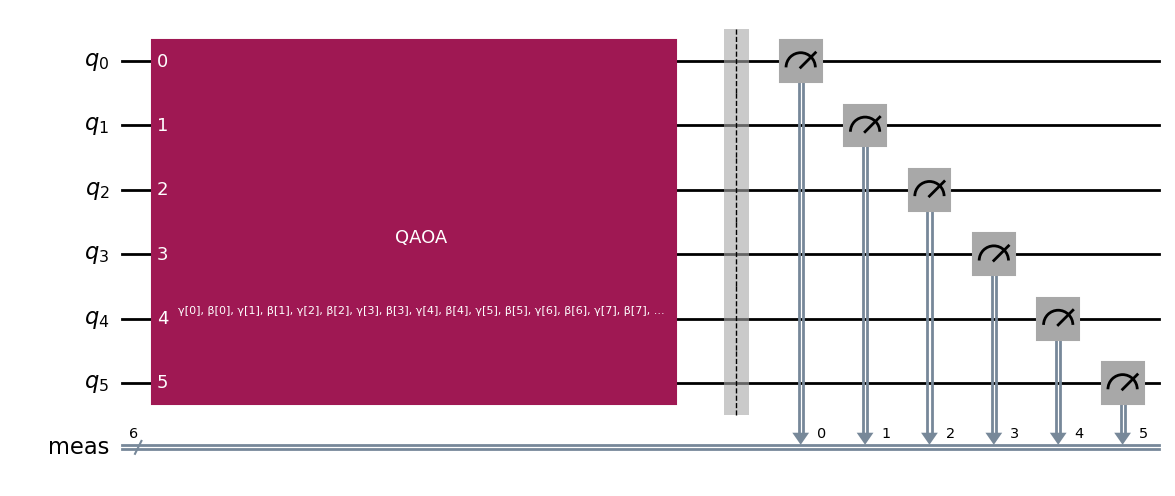

In [575]:
from qiskit.circuit.library import QAOAAnsatz
reps = 30
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=reps)
circuit.measure_all()

circuit.draw('mpl')

In [576]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta] * reps
print("Parameters:", circuit.parameters)
print("Initial params:", init_params)   

Parameters: ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(β[2]), ParameterVectorElement(β[3]), ParameterVectorElement(β[4]), ParameterVectorElement(β[5]), ParameterVectorElement(β[6]), ParameterVectorElement(β[7]), ParameterVectorElement(β[8]), ParameterVectorElement(β[9]), ParameterVectorElement(β[10]), ParameterVectorElement(β[11]), ParameterVectorElement(β[12]), ParameterVectorElement(β[13]), ParameterVectorElement(β[14]), ParameterVectorElement(β[15]), ParameterVectorElement(β[16]), ParameterVectorElement(β[17]), ParameterVectorElement(β[18]), ParameterVectorElement(β[19]), ParameterVectorElement(β[20]), ParameterVectorElement(β[21]), ParameterVectorElement(β[22]), ParameterVectorElement(β[23]), ParameterVectorElement(β[24]), ParameterVectorElement(β[25]), ParameterVectorElement(β[26]), ParameterVectorElement(β[27]), ParameterVectorElement(β[28]), ParameterVectorElement(β[29]), ParameterVectorElement(γ[0]), ParameterVectorElement(

# Resolver el problema

In [577]:
objective_func_vals = []

estimator = AerEstimator()
estimator.set_options(shots=1000)

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    circuit_bound = ansatz.assign_parameters(params)
    job = estimator.run([circuit_bound], [hamiltonian])
    result = job.result()
    cost = result.values[0]
    objective_func_vals.append(cost)
    return cost

result = minimize(
    cost_func_estimator,
    init_params,
    args=(circuit, cost_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-30,
)

print("Optimization Result:\n", result)

Optimization Result:
  message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -1348.8094999999998
       x: [ 3.189e+00  2.556e+00 ...  3.142e+00  1.567e+00]
    nfev: 1000
   maxcv: 0.0


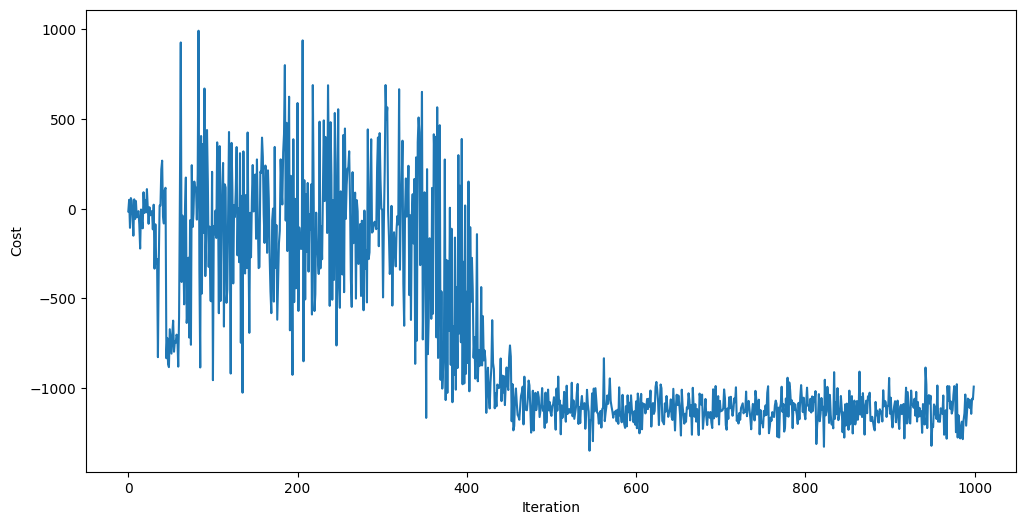

In [578]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

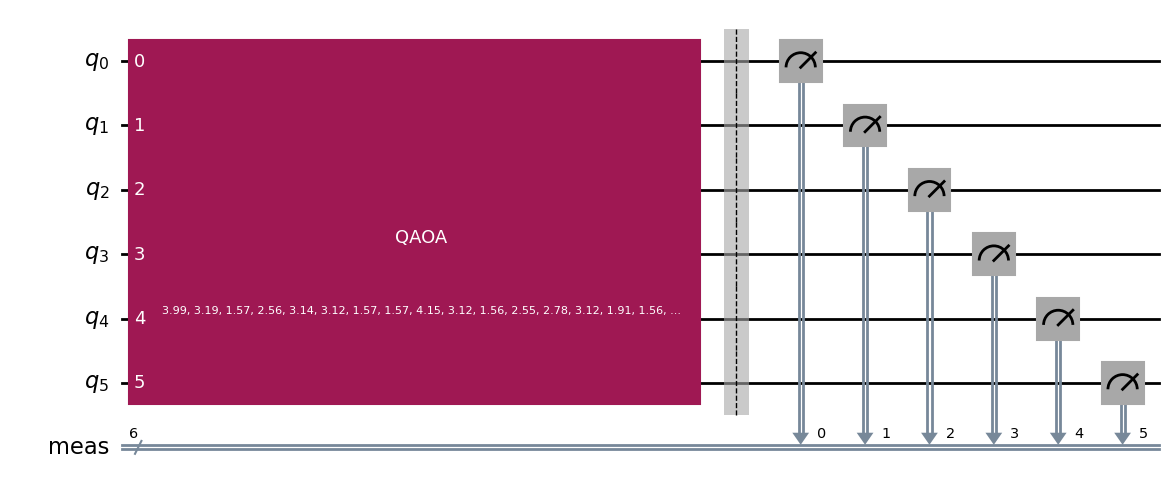

In [579]:
optimized_circuit = circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [580]:
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram


# Transpilar para el simulador
simulator = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(optimized_circuit, simulator)

# Ejecutar el circuito
shots = 10_000
job = simulator.run(transpiled_circuit, backend=simulator, shots=shots)
result = job.result()

# Obtener conteos
counts = result.get_counts()

# Normalizar los resultados
final_distribution = {key: val/shots for key, val in counts.items()}



In [581]:
keys = list(final_distribution.keys())
values = list(final_distribution.values())
most_likely = keys[np.argmax(np.abs(values))]

result_bitstring = [int(digit) for digit in most_likely]
print("Result bitstring as list:", result_bitstring)

Result bitstring as list: [1, 1, 0, 1, 1, 0]


In [582]:
def evaluate_solution(bitstring, n_items, weights, profits, capacity):
    if len(bitstring) != n_items:
        bitstring = bitstring[:n_items]

    total_weight = sum(weights[i] for i in range(len(bitstring)) if bitstring[i] == 1)
    total_profit = sum(profits[i][j] * bitstring[i] * bitstring[j] for i in range(len(bitstring)) for j in range(len(bitstring)))
    
    return total_profit, total_weight <= capacity

total_profit, is_valid = evaluate_solution(result_bitstring, n_items, weights, profits, capacity)
print("Total Profit:", total_profit, "\nValid Solution:", is_valid)

real_solution = [1, 1, 0, 0, 1, 1, 0]
total_profit, is_valid = evaluate_solution(real_solution, n_items, weights, profits, capacity)
print("Total Profit:", total_profit, "\nValid Solution:", is_valid)


Total Profit: 13 
Valid Solution: True
Total Profit: 10 
Valid Solution: True


# QKP using "Implementing Slack-Free Custom Penalty Function  for QUBO on Gate-Based Quantum Computers" by LEE Xin Wei et al. as a reference.
```python